In [1]:
#!pip3 install tqdm
#!pip3 install ipywidgets

In [2]:
#from ipywidgets import IProgress
#!pip install tqdm

use terminal - ```igwn-keras2```

In [3]:
import scipy.io
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [4]:
!wget -P gravity_spy https://github.com/Clarke-Jools-36/diss-gw/blob/main/blip_data/gravity_spy/Blip_strain.mat

--2022-12-22 10:39:11--  https://github.com/Clarke-Jools-36/diss-gw/blob/main/blip_data/gravity_spy/Blip_strain.mat
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘gravity_spy/Blip_strain.mat.8’

Blip_strain.mat.8       [ <=>                ] 136.52K   872KB/s    in 0.2s    

2022-12-22 10:39:12 (872 KB/s) - ‘gravity_spy/Blip_strain.mat.8’ saved [139798]



Import the data, form my github (temporary)

In [5]:

mat = scipy.io.loadmat('gravity_spy/Blip_strain.mat')
#mat = np.loadtxt('gravity_spy/Blip_strain.mat') #depending on what versions of
                                                  # which are installed 
                                                  #sometimes this fails


mat["outData"].shape
n = len(mat["outData"][:,0])

###STFT

This is my short time fourier transform. I have looked through it and i think it is all ok, but i'd apreciate a second pair of eyes here sometime

In [6]:
#BETTER SHORT TIME FOURIER TRANSFORM
def better_stft(data, fs = 1024, fft_size = 32, overlap_fac = 0.8):

    # fs = a scalar which is the sampling frequency of the data
    #fft_size = the size of the fast fourier transform window [power of 2]
    #overlap_fac = the overlap factor [0-1]


    hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
    pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
    t_max = len(data) / np.float32(fs)

    window = np.hanning(fft_size)  # our half cosine window
    inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

    proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
    result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

    for i in range(total_segments):                      # for each segment
        current_hop = hop_size * i                        # figure out the current segment offset
        segment = proc[current_hop:current_hop+fft_size]  # get the current segment
        windowed = segment * window                       # multiply by the half cosine function
        padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
        spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
        autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
        result[i, :] = autopower[:fft_size]               # append to the results array

    #result = 20*np.log10(result)          # scale to db
    #result = np.clip(result,-85, -40)[:-(int(fft_size*0.15)),:].T   # clip values, and remove edge effects
    
    result = result[:-(int(fft_size*0.15)),:].T
    return result



Lets test out the function above with one wave from the data

1024
255


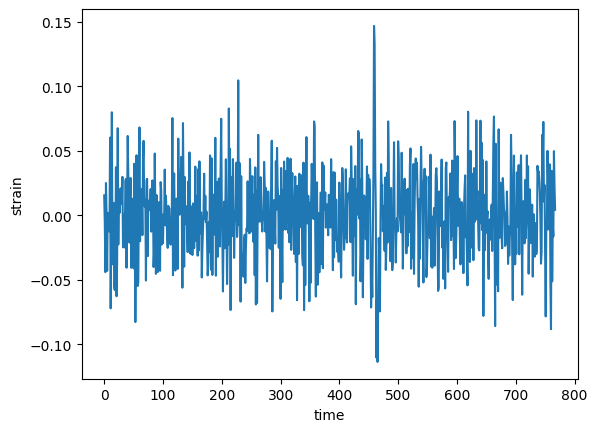

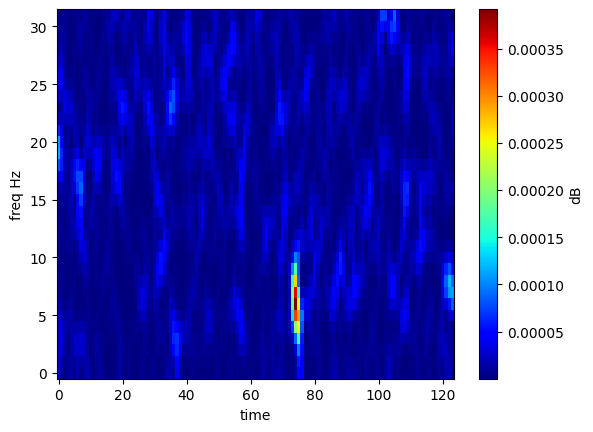

(32, 124)

In [7]:
wave_number = 3
# data = a numpy array containing the signal to be processed
print(n)
print( (int(n/4)-1) )
random_offset = np.random.randint(0, high = (int(n/4)-1) ) #-1 is for security to prevent calling out of bounds
    
data = mat["outData"][:,wave_number][random_offset:random_offset+int((3*n)/4)]

plt.plot(data)
plt.ylabel("strain")
plt.xlabel("time")
plt.figure()

result = better_stft(data)
img = plt.imshow(result, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.ylabel("freq Hz")
plt.xlabel("time")

plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful

plt.show()

result.shape


In [8]:
img_shape = result.shape
img_size = img_shape[0]*img_shape[1]
print(img_shape)
print(img_size)

(32, 124)
3968


Now lets split into test and train

In [9]:
test_train_ratio = 0.8

x_train = np.zeros([int(mat["outData"].shape[1]*test_train_ratio), result.shape[0]*result.shape[1]])
x_test = np.zeros([int(mat["outData"].shape[1]*(1-test_train_ratio))-1, result.shape[0]*result.shape[1]])

print(f'{x_train.shape} {x_test.shape}')

(830, 3968) (206, 3968)


and the convert them all to stft 

In [10]:
for i in np.arange(len(x_train)):
    random_offset = np.random.randint(0, high = (int(n/4)-1) ) #-1 is for security to prevent calling out of bounds
    #random_offset = (int(n/8)-1)
    
    wave_ = mat["outData"][:,i][random_offset:random_offset+int((3*n)/4)]
    
    x_train[i] = better_stft(wave_).reshape((3968,))

In [11]:
for i in np.arange(len(x_test)):
    random_offset = np.random.randint(0, high = (int(n/4)-1) ) #-1 is for security to prevent calling out of bounds
    #random_offset = (int(n/8)-1)
    
    wave_ = mat["outData"][:,i+len(x_train)][random_offset:random_offset+int((3*n)/4)]
    
    x_test[i] = better_stft(wave_).reshape((3968,))

lets plot them to make sure its all ok

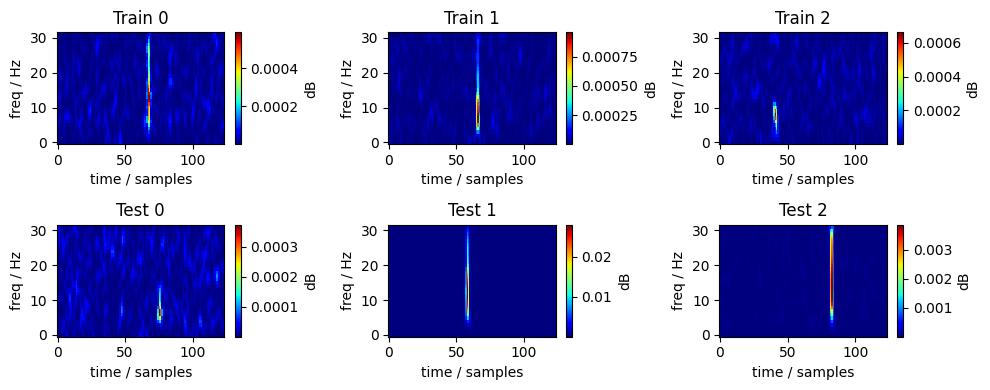

In [12]:
n_ = 3  # How many digits we will display

plt.figure(figsize=(10, 4))
for i in range(n_):
    # Display original
    ax = plt.subplot(2, n_, i + 1)
    
    img = plt.imshow(x_train[i].reshape(img_shape), origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
    plt.ylabel("freq / Hz")
    plt.xlabel("time / samples")
    plt.title(f"Train {i}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n_, i + 1 + n_)
    
    img = plt.imshow(x_test[i].reshape(img_shape), origin='lower',interpolation='nearest', cmap='jet',  aspect='auto')
    plt.ylabel("freq / Hz")
    plt.xlabel("time / samples")
    plt.title(f"Test {i}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()

Check that these first 10 train and test images are different ^^

###Modelling

This is the original dense layer model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(img_size))  #1024 make it this! #####################################
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(img_size, activation='sigmoid')(encoded)  #1024 make it this!####################

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

autoencoder.summary()

2022-12-22 10:39:16.712371: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3968)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                127008    
_________________________________________________________________
dense_1 (Dense)              (None, 3968)              130944    
Total params: 257,952
Trainable params: 257,952
Non-trainable params: 0
_________________________________________________________________


2022-12-22 10:39:17.561422: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-22 10:39:17.562014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-22 10:39:17.596550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 10:39:17.596700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:26:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.455GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-12-22 10:39:17.596719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-22 10:39:17.598129: I tensorflow/stream_executor/platform/def

This is my attempt at using conv2d, but I can't produce a model that will compile

In [14]:
img_shape_ = [img_shape[0], img_shape[1], 1]#3] #apparently it wants a 3d shape but
                                            # that might be for rgb which these
                                            # are not
print(img_shape_)
inputs = keras.Input(shape = (img_shape_))
conv1 = layers.Conv2D(32, kernel_size = (5,5), strides = (1,1), activation = 'relu', input_shape=(img_shape_))(inputs)
max1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)
conv2 = layers.Conv2D(64, (5,5), activation = 'relu')(max1)
max2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
flat = layers.Flatten()(max2)
den1 = layers.Dense(100, activation = 'relu')(flat)
decoded = layers.Dense(img_size, activation='sigmoid')(den1)
decoded = layers.Reshape((img_shape_))(decoded)
# This model maps an input to its reconstruction
autoencoder = keras.Model(inputs, decoded)

autoencoder.summary()

[32, 124, 1]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 124, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 120, 32)       832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 56, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 28, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)      

In [15]:
img_shape_ = [img_shape[0], img_shape[1], 1]
print(img_size)
inputs = keras.Input(shape=(img_size))
reshape1 = layers.Reshape((img_shape_))(inputs)
conv1 = layers.Conv2D(32, kernel_size = (5,5), strides = (1,1), activation = 'relu', input_shape=((img_shape_)))(reshape1)
max1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)
conv2 = layers.Conv2D(64, (5,5), activation = 'relu')(max1)
max2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
flat = layers.Flatten()(max2)
den1 = layers.Dense(100, activation = 'relu')(flat)
print(img_size)
decoded = layers.Dense(img_size, activation='sigmoid')(den1)
# This model maps an input to its reconstruction
autoencoder = keras.Model(inputs, decoded)

autoencoder.summary()

3968
3968
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3968)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 124, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 120, 32)       832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 56, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 28, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8960)        

potentially the kernel wantsa to be (5,y_max) so it searches the whole image at once, but thats to play with once it works.


In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
x_train[0]

array([1.86039495e-06, 7.24893061e-06, 3.28064812e-06, ...,
       2.11980459e-05, 2.02421634e-05, 4.11336032e-06])

0.038618769496679306
1.7021687748434111e-19


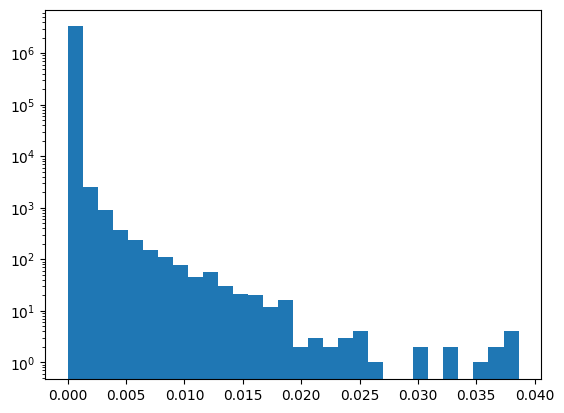

In [18]:
print(max(x_train.flatten()) - min(x_train.flatten()))
print(min(x_train.flatten()))

plt.hist(x_train.flatten(), bins=30)
plt.yscale('log')
plt.show()


###Normailsation

I have tried a few different types of normalisation, but i'm unsure which one to settle on

In [19]:
### NORMALISATION ###
"""
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
"""

"""
normaliserm = max(x_train.flatten()) - min(x_train.flatten())
normaliserc = min(x_train.flatten())
x_train = (x_train-normaliserc) / normaliserm
x_test = (x_test-normaliserc) / normaliserm
"""

"""
normaliserm = np.amax(x_train, axis=0) - np.amin(x_train, axis=0)
normaliserc = np.amin(x_train, axis=0)
x_train = (x_train-normaliserc) / normaliserm
x_test = (x_test-normaliserc) / normaliserm
"""

normaliserm = 0.004

normaliserc = 0
x_train = (x_train-normaliserc) / normaliserm
x_test = (x_test-normaliserc) / normaliserm


print(x_train.shape)
print(x_test.shape)
'''
x_train = x_train.reshape(-1, img_shape[0], img_shape[1], 1)
x_test = x_test.reshape(-1, img_shape[0], img_shape[1], 1)

print(x_train.shape)
print(x_test.shape)
'''

(830, 3968)
(206, 3968)


'\nx_train = x_train.reshape(-1, img_shape[0], img_shape[1], 1)\nx_test = x_test.reshape(-1, img_shape[0], img_shape[1], 1)\n\nprint(x_train.shape)\nprint(x_test.shape)\n'

###Train

In [20]:
history = autoencoder.fit(x_train, x_train,
                epochs=100, #50
                batch_size=256, #256
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100


2022-12-22 10:39:19.593971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-22 10:39:19.613820: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393155000 Hz
2022-12-22 10:39:19.941551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-22 10:39:20.051972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-12-22 10:39:20.480671: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-12-22 10:39:20.516813: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-22 10:39:22.635606: W tensorflow/core/c

4/4 [==============================] - 7s 1s/step - loss: 0.6927 - val_loss: 0.6901
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 0.6875 - val_loss: 0.6530
Epoch 3/100
4/4 [==============================] - 0s 61ms/step - loss: 0.6216 - val_loss: 0.3820
Epoch 4/100
4/4 [==============================] - 0s 62ms/step - loss: 0.2953 - val_loss: 0.0546
Epoch 5/100
4/4 [==============================] - 0s 61ms/step - loss: 0.0568 - val_loss: 0.0909
Epoch 6/100
4/4 [==============================] - 0s 61ms/step - loss: 0.0987 - val_loss: 0.1132
Epoch 7/100
4/4 [==============================] - 0s 61ms/step - loss: 0.1144 - val_loss: 0.0992
Epoch 8/100
4/4 [==============================] - 0s 62ms/step - loss: 0.0963 - val_loss: 0.0728
Epoch 9/100
4/4 [==============================] - 0s 61ms/step - loss: 0.0681 - val_loss: 0.0542
Epoch 10/100
4/4 [==============================] - 0s 61ms/step - loss: 0.0511 - val_loss: 0.0464
Epoch 11/100
4/4 [===============

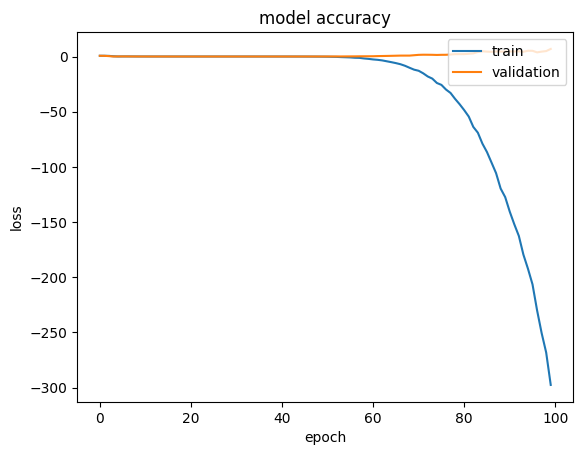

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
decoded_imgs = autoencoder.predict(x_test)

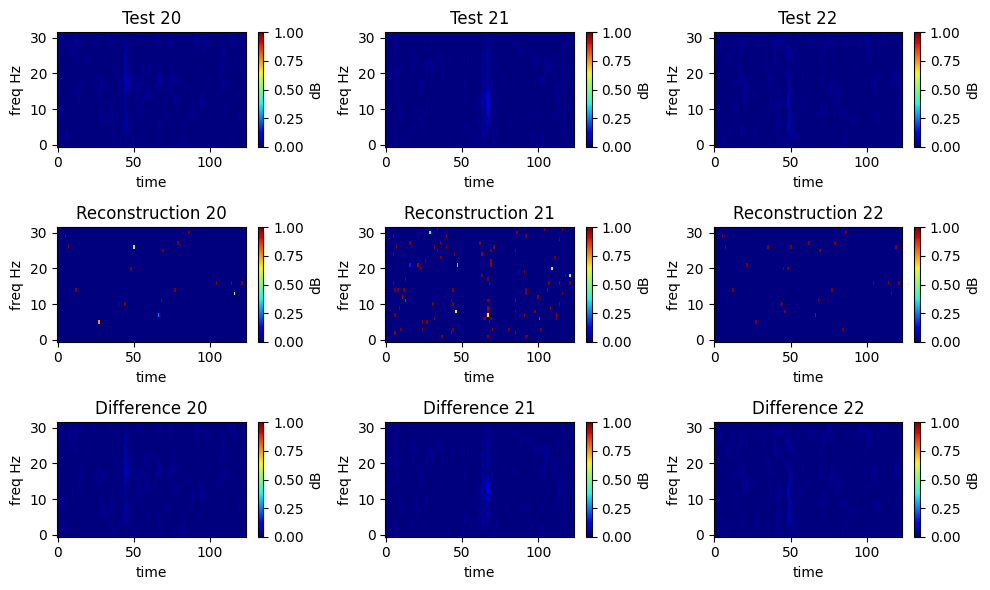

In [28]:
n_ = 3 # How many digits we will display
offset = 20

plt.figure(figsize=(10, 6))
for i in range(n_):
    # Display original
    ax = plt.subplot(3, n_, i + 1)
    
    img = plt.imshow(x_test[i+offset].reshape(img_shape), origin='lower', cmap='jet', interpolation='nearest', aspect='auto', vmin = 0, vmax = 1)
    plt.ylabel("freq Hz")
    plt.xlabel("time")
    plt.title(f"Test {i+offset}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    

    # Display reconstruction
    ax = plt.subplot(3, n_, i + 1 + n_)
    
    img = plt.imshow(decoded_imgs[i+offset].reshape(img_shape), origin='lower',interpolation='nearest', cmap='jet',  aspect='auto', vmin = 0, vmax = 1)
    plt.ylabel("freq Hz")
    plt.xlabel("time")
    plt.title(f"Reconstruction {i+offset}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    
    # Display Diff
    ax = plt.subplot(3, n_, i + 1 + 2*n_)
    
    img = plt.imshow((x_test[i+offset]-decoded_imgs[i+offset]).reshape(img_shape), origin='lower',interpolation='nearest', cmap='jet',  aspect='auto', vmin = 0, vmax = 1)
    plt.ylabel("freq Hz")
    plt.xlabel("time")
    plt.title(f"Difference {i+offset}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    

plt.show()

add all signals and should get a number thats even if noise, kai squared distribution statistically 

In [24]:
sum_diff = np.zeros_like(decoded_imgs[:,1])

for i, decoded in enumerate(decoded_imgs):
    sum_diff[i] = np.sum(x_test[i]-decoded_imgs[i])

sum_diff.shape
#np.savetxt(f"m_moving{normaliserm}.txt", sum_diff)

(206,)

The better the performance, we should see the sum differnce near zero

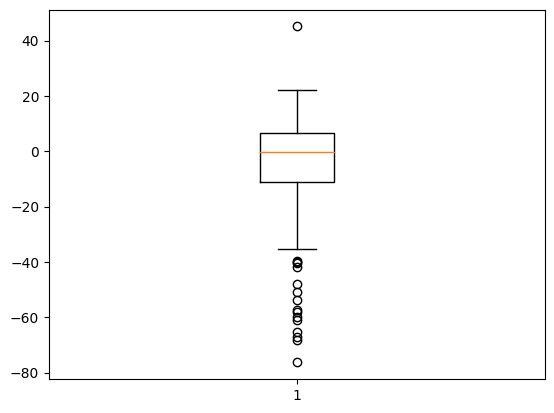

In [25]:
plt.boxplot(sum_diff)
plt.show()